In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import tqdm
import numpy
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

## Data Preparation

In [2]:
# generate data
#X, y = datasets.make_classification(n_samples=10000, n_features=50, n_redundant=10, n_informative=10,
#                           random_state=1, n_clusters_per_class=2,n_classes=3, class_sep=2)

X,y = datasets.make_classification(n_samples=10000, n_features=50, n_redundant=10,n_informative=20,random_state=1,n_classes=2, class_sep=2)

                                   
# divide data in Train - Validation - Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 

# Standardize Data
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

<AxesSubplot:title={'center':'Feature wise Variance'}, xlabel='Features', ylabel='Variance'>

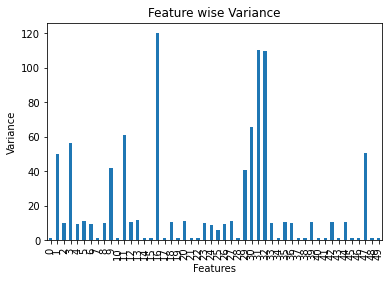

In [3]:
df_train = pd.DataFrame(X_tr)
df_train.var().plot(kind='bar',xlabel='Features', ylabel='Variance', title='Feature wise Variance')

## Comparing Auto encoder with PCA

In [4]:
class Dataset(object):
 
    def __init__(self,features,labels):
        self.data = features
        self.labels = labels

    def __getitem__(self, index):
        return torch.FloatTensor(self.data[index]).reshape(-1),self.labels[index]

    def __len__(self):
        return len(self.data)

train_dataset = Dataset(X_tr_std,y_tr)
val_dataset = Dataset(X_valid_std,y_valid)
test_dataset  = Dataset(X_test_std,y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

## Simple Linear auto enoder model

In [5]:
class SimpleAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(50, 5))
        self.decoder = nn.Sequential(nn.Linear(5, 50))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self,x):
        x = self.encoder(x)
        return x
    
    def decode(self,x):
        x = self.decoder(x)
        return x
        

### Using Early stopping while training 


In [6]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum %age difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif (self.best_loss - val_loss)/self.best_loss*100 > self.min_delta:
            self.best_loss = val_loss
        elif (self.best_loss - val_loss)/self.best_loss*100 < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

### Training and validation functions

In [7]:
# training function
def fit(model, train_dataloader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    
    for data in train_dataloader:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

def validate(model, val_dataloader, criterion):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    
    with torch.no_grad():
        for data in val_dataloader:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, data)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss


In [8]:
def train(model,train_loader,val_loader,args):

    if args['early_stopping']:
        early_stopping = EarlyStopping()
    count=0
    train_loss = []
    val_loss = []
    start = time.time()
    for epoch in range(args['epochs']):
        train_epoch_loss = fit(
            model, train_loader, args['optimizer'], args['criterion']
        )
        val_epoch_loss = validate(
            model, val_loader,  args['criterion']
        )
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        if args['lr_scheduler']:
            lr_scheduler(val_epoch_loss)
        if args['early_stopping']:
            early_stopping(val_epoch_loss)
            if early_stopping.early_stop:
                break

        print(f"Epoch: {count}, Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
        count+=1
    end = time.time()
    print(f"Training time: {(end-start)/60:.3f} minutes")
    return train_loss, val_loss

In [9]:
def plot_losses(train_loss,val_loss):
    plt.figure(figsize=(10, 7))
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

In [10]:
#  The arguments will be same for each model for fair comparison
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
args={}
args['lr_scheduler']  =False
args['early_stopping']=True
args['criterion']     = criterion
args['epochs']        = 150

Epoch: 0, Train Loss: 1.0166, Val Loss: 0.9556
Epoch: 1, Train Loss: 0.9181, Val Loss: 0.9030
Epoch: 2, Train Loss: 0.8749, Val Loss: 0.8681
Epoch: 3, Train Loss: 0.8418, Val Loss: 0.8387
Epoch: 4, Train Loss: 0.8129, Val Loss: 0.8121
Epoch: 5, Train Loss: 0.7869, Val Loss: 0.7880
Epoch: 6, Train Loss: 0.7636, Val Loss: 0.7664
Epoch: 7, Train Loss: 0.7430, Val Loss: 0.7477
Epoch: 8, Train Loss: 0.7257, Val Loss: 0.7321
Epoch: 9, Train Loss: 0.7116, Val Loss: 0.7196
Epoch: 10, Train Loss: 0.7003, Val Loss: 0.7098
Epoch: 11, Train Loss: 0.6915, Val Loss: 0.7020
Epoch: 12, Train Loss: 0.6845, Val Loss: 0.6958
Epoch: 13, Train Loss: 0.6790, Val Loss: 0.6909
Epoch: 14, Train Loss: 0.6745, Val Loss: 0.6868
Epoch: 15, Train Loss: 0.6708, Val Loss: 0.6835
Epoch: 16, Train Loss: 0.6677, Val Loss: 0.6806
Epoch: 17, Train Loss: 0.6650, Val Loss: 0.6780
Epoch: 18, Train Loss: 0.6626, Val Loss: 0.6759
Epoch: 19, Train Loss: 0.6606, Val Loss: 0.6739
Epoch: 20, Train Loss: 0.6588, Val Loss: 0.6722
Ep

<Figure size 720x504 with 0 Axes>

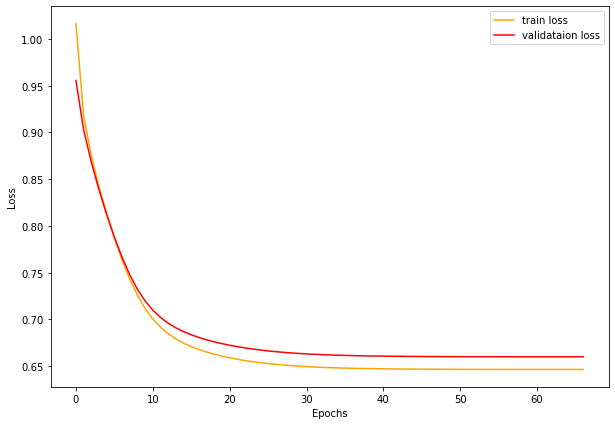

In [11]:
if 'model_AE' in locals():
    del model_AE
    
model_AE = SimpleAE()
model_AE.to(device)

optimizer = torch.optim.SGD(model_AE.parameters(), lr=0.01)
args['optimizer']     = optimizer

train_loss, val_loss = train(model_AE,train_loader,val_loader,args)
plot_losses(train_loss,val_loss)

In [12]:
def encode(model,data):
    model.eval()
    with torch.no_grad():
        outputs = np.array(model.encode(torch.FloatTensor(data).to(device)).cpu())
    return outputs

def decode(model,data):
    model.eval()
    with torch.no_grad():
        outputs = np.array(model.decode(torch.FloatTensor(data).to(device)).cpu())
    return outputs


## Standard deviation of each component in projections 

In [13]:
encodings_AE = pd.DataFrame(encode(model_AE,X_tr_std))
pca = PCA(n_components=5,svd_solver='auto')
scores = pca.fit_transform(X_tr_std) 
encodings_pca1 = pd.DataFrame(numpy.array(pca.transform(X_tr_std)))

<AxesSubplot:title={'center':'Autoencoder'}, xlabel='components', ylabel='standard deviation'>

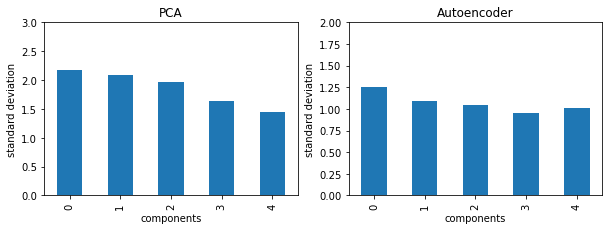

In [14]:
fig, axes = plt.subplots(2, 2)
fig.delaxes(axes[1][0])
fig.delaxes(axes[1][1])
encodings_pca1.std().plot(kind='bar',ax=axes[0,0],ylabel='standard deviation',xlabel='components',title='PCA',grid=False,xticks=encodings_pca1.columns,ylim =(0,3) ,figsize=(10,7))
encodings_AE.std().plot(kind='bar',title='Autoencoder',ylabel='standard deviation',xlabel='components', ax=axes[0,1],grid=False,xticks=encodings_AE.columns,ylim =(0,2) ,figsize=(10,7))

### Observations
1. In PCA, the top principle component carries maximum information (explain maximum variance).
2. In autoencoder, there is no such constraint

## Correlation test

<AxesSubplot:title={'center':'Autoencoder'}>

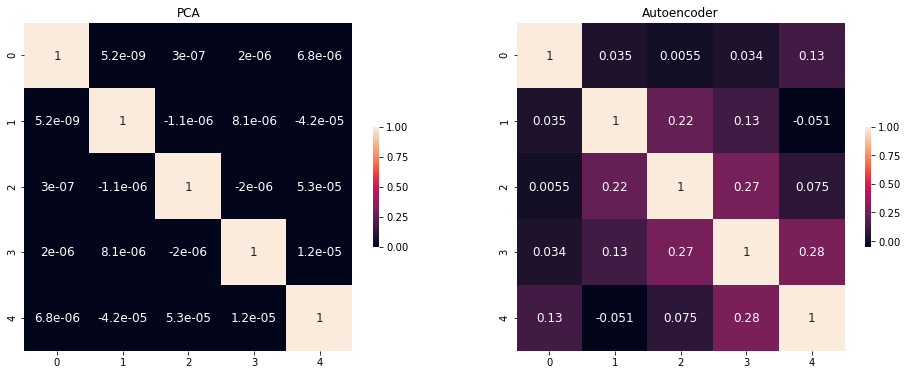

In [15]:
fig = plt.figure(figsize = (25,25)) # width x height
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax2 = fig.add_subplot(3, 3, 2)
ax1.set_title('PCA')
ax2.set_title('Autoencoder')
sns.heatmap(data=encodings_pca1.corr(), ax=ax1, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=encodings_AE.corr(), ax=ax2,  square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

### Observation
In PCA, all the principle components are orthogonal in nature, which implies least or no correlation, where as in autoencoder there is no such constraints, which implies the encodings may have correlations in case of autoencoder's encodings

## Performance

(0.9, 1.0)

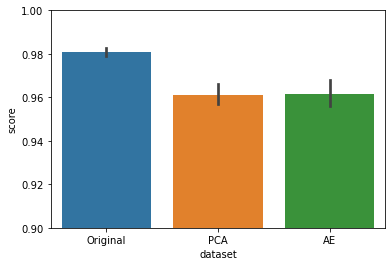

In [16]:
train_encodings_AE  = pd.DataFrame(encode(model_AE,X_tr_std))
train_encodings_pca = pd.DataFrame(numpy.array(pca.transform(X_tr_std)))

rfc = RandomForestClassifier(n_estimators=200, max_depth=5)

labels = ['Original', 'PCA','AE']
scores = pd.DataFrame(columns=labels)
scores['PCA'] = cross_val_score(rfc, train_encodings_pca, y_tr, cv=5)
scores['AE'] = cross_val_score(rfc, train_encodings_AE, y_tr, cv=5)
scores['Original'] = cross_val_score(rfc, X_tr_std, y_tr, cv=5)
sns.barplot(x='dataset', y='score', data = scores.melt(value_name='score', var_name='dataset'))
plt.ylim(0.9,1)

### Observations
As expected the cross validation score should decrease in comparison to original feature set, But auto encoder performance is the least. Lets try to make the autoencoder a bit deep

## Linear Stacked Encoder-Decoder

In [17]:
class StackedLinearAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_l1 = nn.Sequential(nn.Linear(50, 20))
        self.encoder_l2 = nn.Sequential(nn.Linear(20, 5))
        self.decoder_l1 = nn.Sequential(nn.Linear(5, 20))
        self.decoder_l2 = nn.Sequential(nn.Linear(20, 50))
        
    def forward(self, x):
        x = self.encoder_l1(x)
        x = self.encoder_l2(x)
        x = self.decoder_l1(x)
        x = self.decoder_l2(x)
        return x
    
    def encode(self,x):
        x = self.encoder_l1(x)
        x = self.encoder_l2(x)
        return x
    
    def decode(self,x):
        x = self.decoder_l1(x)
        x = self.decoder_l2(x)
        return x

Epoch: 0, Train Loss: 1.0006, Val Loss: 0.9647
Epoch: 1, Train Loss: 0.9190, Val Loss: 0.8909
Epoch: 2, Train Loss: 0.8453, Val Loss: 0.8196
Epoch: 3, Train Loss: 0.7817, Val Loss: 0.7673
Epoch: 4, Train Loss: 0.7373, Val Loss: 0.7321
Epoch: 5, Train Loss: 0.7102, Val Loss: 0.7126
Epoch: 6, Train Loss: 0.6951, Val Loss: 0.7018
Epoch: 7, Train Loss: 0.6862, Val Loss: 0.6950
Epoch: 8, Train Loss: 0.6803, Val Loss: 0.6905
Epoch: 9, Train Loss: 0.6763, Val Loss: 0.6874
Epoch: 10, Train Loss: 0.6735, Val Loss: 0.6851
Epoch: 11, Train Loss: 0.6714, Val Loss: 0.6836
Epoch: 12, Train Loss: 0.6699, Val Loss: 0.6823
Epoch: 13, Train Loss: 0.6687, Val Loss: 0.6812
Epoch: 14, Train Loss: 0.6676, Val Loss: 0.6802
Epoch: 15, Train Loss: 0.6666, Val Loss: 0.6792
Epoch: 16, Train Loss: 0.6656, Val Loss: 0.6782
Epoch: 17, Train Loss: 0.6645, Val Loss: 0.6772
Epoch: 18, Train Loss: 0.6635, Val Loss: 0.6760
Epoch: 19, Train Loss: 0.6624, Val Loss: 0.6749
Epoch: 20, Train Loss: 0.6614, Val Loss: 0.6736
Ep

<Figure size 720x504 with 0 Axes>

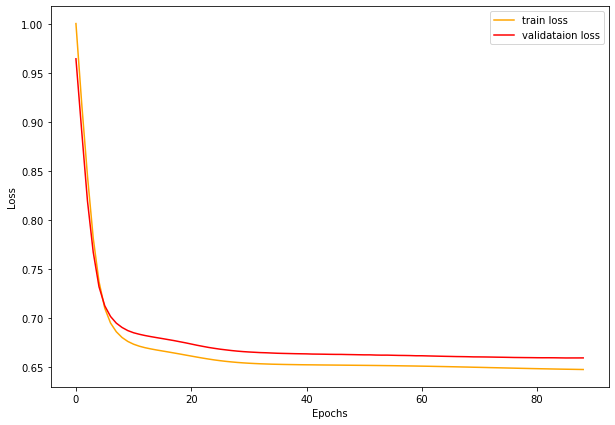

In [18]:
if 'model_stacked_AE' in locals():
    del model_stacked_AE
    
model_stacked_AE = StackedLinearAE()
model_stacked_AE.to(device)

optimizer = torch.optim.SGD(model_stacked_AE.parameters(), lr=0.01)
args['optimizer']     = optimizer

train_loss, val_loss = train(model_stacked_AE,train_loader,val_loader,args)
plot_losses(train_loss,val_loss)

(0.9, 1.0)

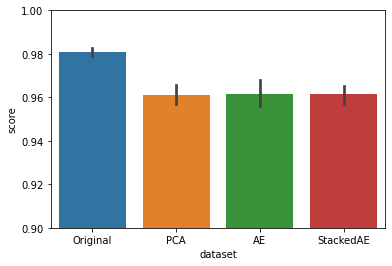

In [19]:
encodings_autoencoder2 = pd.DataFrame(encode(model_stacked_AE,X_tr_std))
rfc = RandomForestClassifier(n_estimators=200, max_depth=5)
scores['StackedAE'] = cross_val_score(rfc, encodings_autoencoder2, y_tr, cv=5)
sns.barplot(x='dataset', y='score', data = scores.melt(value_name='score', var_name='dataset'))
plt.ylim(0.9,1)

## No linear stacked AE

In [20]:
class NonLinearAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_l1 = nn.Sequential(nn.Linear(50, 20))
        self.encoder_l2 = nn.Sequential(nn.Linear(20, 5))
        self.decoder_l1 = nn.Sequential(nn.Linear(5, 20))
        self.decoder_l2 = nn.Sequential(nn.Linear(20, 50))
        
    def forward(self, x):
        x = self.encoder_l1(x)
        x = torch.relu(x)
        x = self.encoder_l2(x)
        x = self.decoder_l1(x)
        x = torch.relu(x)
        x = self.decoder_l2(x)
        return x
    
    def encode(self,x):
        x = self.encoder_l1(x)
        x = torch.relu(x)
        x = self.encoder_l2(x)
        return x
    
    def decode(self,x):
        x = self.decoder_l1(x)
        x = torch.relu(x)
        x = self.decoder_l2(x)
        return x

Epoch: 0, Train Loss: 1.0189, Val Loss: 1.0129
Epoch: 1, Train Loss: 0.9983, Val Loss: 0.9995
Epoch: 2, Train Loss: 0.9863, Val Loss: 0.9873
Epoch: 3, Train Loss: 0.9721, Val Loss: 0.9703
Epoch: 4, Train Loss: 0.9508, Val Loss: 0.9449
Epoch: 5, Train Loss: 0.9211, Val Loss: 0.9120
Epoch: 6, Train Loss: 0.8864, Val Loss: 0.8775
Epoch: 7, Train Loss: 0.8536, Val Loss: 0.8478
Epoch: 8, Train Loss: 0.8277, Val Loss: 0.8256
Epoch: 9, Train Loss: 0.8072, Val Loss: 0.8067
Epoch: 10, Train Loss: 0.7877, Val Loss: 0.7881
Epoch: 11, Train Loss: 0.7689, Val Loss: 0.7721
Epoch: 12, Train Loss: 0.7533, Val Loss: 0.7602
Epoch: 13, Train Loss: 0.7417, Val Loss: 0.7512
Epoch: 14, Train Loss: 0.7325, Val Loss: 0.7439
Epoch: 15, Train Loss: 0.7249, Val Loss: 0.7374
Epoch: 16, Train Loss: 0.7181, Val Loss: 0.7314
Epoch: 17, Train Loss: 0.7115, Val Loss: 0.7249
Epoch: 18, Train Loss: 0.7048, Val Loss: 0.7183
Epoch: 19, Train Loss: 0.6977, Val Loss: 0.7111
Epoch: 20, Train Loss: 0.6902, Val Loss: 0.7036
Ep

<Figure size 720x504 with 0 Axes>

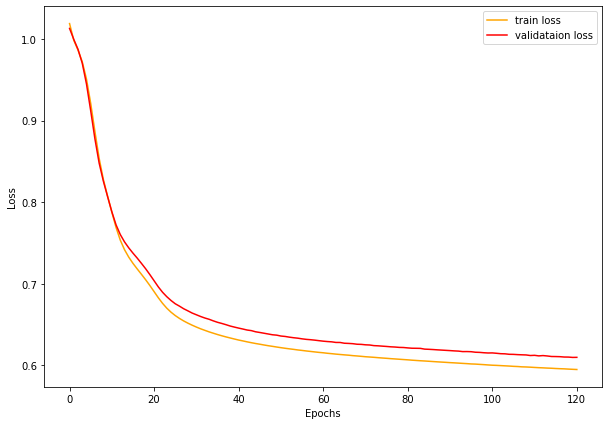

In [24]:
if 'model_NL_AE' in locals():
    del model_NL_AE
    
model_NL_AE = NonLinearAE()
model_NL_AE.to(device)

optimizer = torch.optim.SGD(model_NL_AE.parameters(), lr=0.01)
args['optimizer']     = optimizer

train_loss, val_loss = train(model_NL_AE,train_loader,val_loader,args)
plot_losses(train_loss,val_loss)

(0.9, 1.0)

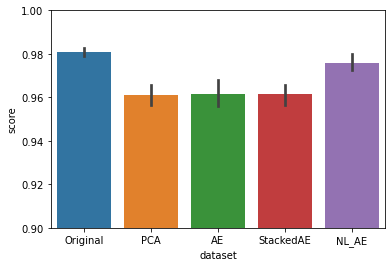

In [34]:
encodings_autoencoder3 = pd.DataFrame(encode(model_NL_AE,X_tr_std))
rfc = RandomForestClassifier(n_estimators=200, max_depth=5)
scores['NL_AE'] = cross_val_score(rfc, encodings_autoencoder3, y_tr, cv=5)
sns.barplot(x='dataset', y='score', data = scores.melt(value_name='score', var_name='dataset'))
plt.ylim(0.9,1)

## Reconstruction error

<AxesSubplot:ylabel='Mean squared error'>

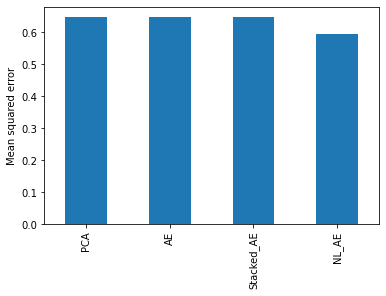

In [32]:
from sklearn.metrics import mean_squared_error
PCA_decoded             = pca.inverse_transform(pca.transform(X_tr_std)) 
AE_decoded              = decode(model_AE,encode(model_AE,X_tr_std))
stacked_AE_decoded      = decode(model_stacked_AE,encode(model_stacked_AE,X_tr_std))
NL_AE_decoded = decode(model_NL_AE,encode(model_NL_AE,X_tr_std))

labels = ['PCA','AE','Stacked_AE','NL_AE']
mse = pd.DataFrame(columns=labels)

mse['PCA']        = [mean_squared_error(PCA_decoded, X_tr_std)]
mse['AE']         = [mean_squared_error(AE_decoded, X_tr_std)]
mse['Stacked_AE'] = [mean_squared_error(stacked_AE_decoded, X_tr_std)]
mse['NL_AE']      = [mean_squared_error(NL_AE_decoded, X_tr_std)]
mse.iloc[0].plot(kind='bar',ylabel='Mean squared error')

## Testing linear and non linear datasets

In [ ]:

# data set 1
x_dummy = np.linspace(start=1, stop=10, num=10000)
y_dummy = x_dummy*2
noise = np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

dataset1 = pd.DataFrame(columns=('x1','x2'))
dataset1['x1'] = x_dummy
dataset1['x2'] = y_dummy
sc = StandardScaler()
dataset1 = pd.DataFrame(sc.fit_transform(dataset1), columns=('x1','x2'))


x_dummy = np.linspace(start=1, stop=10, num=10000)
y_dummy = x_dummy*x_dummy
noise = np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

dataset2 = pd.DataFrame(columns=('x1','x2'))
dataset2['x1'] = x_dummy
dataset2['x2'] = y_dummy
sc = StandardScaler()
dataset2 = pd.DataFrame(sc.fit_transform(dataset2), columns=('x1','x2'))

x_dummy = np.linspace(start=1, stop=10, num=10000)
y_dummy = np.exp(x_dummy)
noise = np.random.normal(size=y_dummy.size)
y_dummy = y_dummy + noise

dataset3 = pd.DataFrame(columns=('x1','x2'))
dataset3['x1'] = x_dummy
dataset3['x2'] = y_dummy
sc = StandardScaler()
dataset3 = pd.DataFrame(sc.fit_transform(dataset3), columns=('x1','x2'))

x1 = np.linspace(start=1, stop=10, num=10000)
x2 = x1*x1
noise = np.random.normal(size=y_dummy.size)
x2 = x2 + noise

x3 = 2*x1 + np.random.normal(size=y_dummy.size)



dataset4 = pd.DataFrame(columns=('x1','x2','x3'))
dataset4['x1'] = x1
dataset4['x2'] = x2
dataset4['x3'] = x3
sc = StandardScaler()
dataset4 = pd.DataFrame(sc.fit_transform(dataset4), columns=('x1','x2','x3'))


In [ ]:
def f(x, y):
    #import pdb;pdb.set_trace()
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)
dataset=[]
for i in range(30):
    for j in range(30):
        dataset.append([x[i],y[j],f(x[i],y[j])])



In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(np.array(dataset)[:,0], np.array(dataset)[:,1], np.array(dataset)[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
Z.shape

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(dataset4['x1'], dataset4['x2'], dataset4['x3'], 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
pca = PCA(n_components=1,svd_solver='auto')
dataset1_encoded_pca = pd.DataFrame(pca.fit_transform(dataset1))
dataset1_decoded_pca = pd.DataFrame(pca.inverse_transform(dataset1_encoded_pca),columns=('x1','x2'))

pca = PCA(n_components=1,svd_solver='auto')
dataset2_encoded_pca = pd.DataFrame(pca.fit_transform(dataset2))
dataset2_decoded_pca = pd.DataFrame(pca.inverse_transform(dataset2_encoded_pca),columns=('x1','x2'))

pca = PCA(n_components=1,svd_solver='auto')
dataset3_encoded_pca = pd.DataFrame(pca.fit_transform(dataset3))
dataset3_decoded_pca = pd.DataFrame(pca.inverse_transform(dataset3_encoded_pca),columns=('x1','x2'))



In [ ]:
plt.scatter(dataset1['x1'], dataset1['x2'], s=20, color='#00b3b3', label='Data')

In [ ]:
plt.scatter(dataset1_decoded_pca['x1'], dataset1_decoded_pca['x2'], s=20, color='#00b3b3', label='Data')

In [ ]:
plt.scatter(dataset3['x1'], dataset3['x2'], s=20, color='#00b3b3', label='Data')

In [ ]:
plt.scatter(dataset3_decoded_pca['x1'], dataset3_decoded_pca['x2'], s=20, color='#00b3b3', label='Data')

In [ ]:
class SimpleAE2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(2, 1))
        self.decoder = nn.Sequential(nn.Linear(1, 2))
        
    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        x = torch.relu(x)
        return x
    
    def encode(self,x):
        x = self.encoder(x)
        x = torch.relu(x)
        return x
    
    def decode(self,x):
        x = self.decoder(x)
        x = torch.relu(x)
        return x

In [ ]:
model4 = SimpleAE2()
model4.to(device)
optimizer = torch.optim.SGD(model4.parameters(), lr=0.001)
args['early_stopping']=True
early_stopping = EarlyStopping(patience=10, min_delta=0)

In [ ]:
class Dataset(object):
 
    def __init__(self,features):
        self.data = features
        
    def __getitem__(self, index):
        return torch.FloatTensor(self.data[index]).reshape(-1)
    
    def __len__(self):
        return len(self.data)

    
X_train = np.array(dataset3.iloc[0:int(dataset3.shape[0]*0.8)])
X_valid = np.array(dataset3.iloc[int(dataset3.shape[0]*0.8):])   
    
train_dataset = Dataset(X_train)
val_dataset = Dataset(X_valid)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [ ]:
# training function
def fit(model, train_dataloader, train_dataset, optimizer, criterion,print_status):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    #prog_bar = tqdm.tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    #for i, data in prog_bar:
    #import pdb;pdb.set_trace()
    for data in train_dataloader:
        counter += 1
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

# validation function
def validate(model, val_dataloader, val_dataset, criterion,print_status):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    #prog_bar = tqdm.tqdm(enumerate(val_dataloader), total=int(len(val_dataset)/val_dataloader.batch_size))
    with torch.no_grad():
     
        #for i, data in prog_bar:
        for data in val_dataloader:
            counter += 1
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

def encode(model,data):
    model.eval()
    with torch.no_grad():
        outputs = np.array(model.encode(torch.FloatTensor(data).to(device)).cpu())
    return outputs

def decode(model,data):
    model.eval()
    with torch.no_grad():
        outputs = np.array(model.decode(torch.FloatTensor(data).to(device)).cpu())
    return outputs


In [ ]:
# lists to store per-epoch loss and accuracy values
train_loss = []
val_loss = []
start = time.time()
count=1
for epoch in range(1000):
    #print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(
        model4, train_loader, train_dataset, optimizer, criterion,print_status=False
    )
    val_epoch_loss = validate(
        model4, val_loader, val_dataset, criterion, print_status=False
    )
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break

    print(f"Epoch: {count} : Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
    count+=1

end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")


In [ ]:
plt.figure(figsize=(10, 7))
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
encoded

In [ ]:
encoded = encode(model4,X_train)
decoded = decode(model4,encoded)

In [ ]:
plt.scatter(decoded[:,0], decoded[:,1],s=20, color='#00b3b3', label='Data')

In [ ]:
plt.scatter(decoded['x1'], decoded['x2'], s=20, color='#00b3b3', label='Data')

In [ ]:
import torch.onnx
dummy_input = torch.FloatTensor(X_tr_std).to(device)
torch.onnx.export(model, dummy_input, "model.png")